# Plotting: Data

This notebook is used to generate all the "data" plots (samples, distribution of IDs, etc) in the paper.

## Setup

In [1]:
plot_dir = "../plots/data/"
data_base = "../data/"

In [2]:
import os

from util.data import TFRecordLoader

2023-05-04 17:03:08.850882: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


In [3]:
import numpy as np
import tensorflow as tf

In [4]:
import matplotlib.pyplot as plt

import seaborn as sns

#palette = 'colorblind'
colors = [
    (190, 15, 52),
    (72, 145, 220),
    (0, 119, 112),
    (207, 122, 48),
    (235, 196, 203),
]
colors_hex = [f'#{r:02x}{g:02x}{b:02x}' for r, g, b in colors]

sns.set_theme(palette=colors_hex, color_codes=True)
sns.set_style('ticks')
sns.set_context('notebook')
sns.color_palette(colors_hex)

plt.rcParams['figure.dpi'] = 72

# Plotting Samples

In [5]:
save_dir = data_base + "/models"
data_dir = data_base + "/tfrecord"
file_data = os.path.join(data_dir, "data-8.tfrecord")

num_samples = 11000 # = 880*12.5
seed = 20220615

shuffle_buffer_sample = 1000
group_window_size = 4
batch_size = 32

learning_rate = 1e-5

ds_test = TFRecordLoader.from_file(file_data, shuffle_buffer_sample, seed)
ds_test = TFRecordLoader.window_batch(ds_test, group_window_size, batch_size)
ds_test = ds_test.prefetch(tf.data.experimental.AUTOTUNE)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


2023-05-04 17:03:18.438801: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2023-05-04 17:03:18.440505: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2023-05-04 17:03:18.499426: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:82:00.0 name: TITAN RTX computeCapability: 7.5
coreClock: 1.77GHz coreCount: 72 deviceMemorySize: 23.65GiB deviceMemoryBandwidth: 625.94GiB/s
2023-05-04 17:03:18.499474: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2023-05-04 17:03:18.897279: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2023-05-04 17:03:18.897468: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublasLt.so.10
2023-05-04 1

In [6]:
# Grab a batch of data to use for plotting
num_batches = 1
samples_test = []
labels_test = []
for i, (x, y) in enumerate(ds_test.take(num_batches)):
    if i == num_batches:
        break
    samples_test.append(x.numpy())
    labels_test.append(y.numpy())

samples_test = np.concatenate(samples_test)
labels_test = np.concatenate(labels_test)

2023-05-04 17:03:24.504468: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2023-05-04 17:03:24.533244: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2600075000 Hz


In [10]:
# Plot a single sample
def plot_sample(sample, figsize=5, output_pdf=None, show=True):
    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(2*figsize, 1*figsize))
    ax = axs[0]
    x = np.arange(sample.shape[0], dtype=np.float64)
    print(x.shape)
    x /= 25000000
    x *= 1e3
    ax.plot(x, sample[:,0], label='Real')
    ax.plot(x, sample[:,1], label='Imaginary')
    ax.set_xlabel('Time (ms)')
    ax.set_ylabel('Amplitude')
    ax.legend(loc='upper left')
    ax = axs[1]
    ax.plot(sample[:,0], sample[:,1])
    ax.set_xlabel('Amplitude (Real)')
    ax.set_ylabel('Amplitude (Imaginary)')

    if output_pdf:
        plt.savefig(os.path.join(plot_dir, output_pdf), bbox_inches='tight')

    if show:
        plt.show()

(11000,)


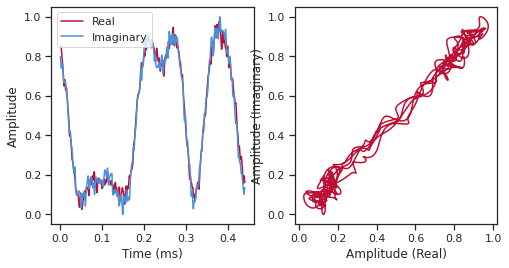

In [14]:
plot_sample(samples_test[0], output_pdf="sample.pdf", figsize=4)

(11000,)


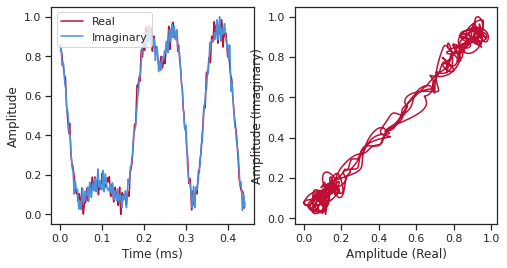

In [15]:
plot_sample(samples_test[10], output_pdf="sample-2.pdf", figsize=4)

In [19]:
del samples_test
del labels_test
del ds_test

## Distribution of Transmitters

In [16]:
data_dir = data_base
suffixes = [f"{i:03d}" for i in range(171)]

In [17]:
def get_id_cell(sat_id, sat_cell, num_cells=63):
    return sat_id * num_cells + sat_cell

def load_data(path, suffix):
    file_ids = os.path.join(path, f"ra_sat_{suffix}.npy")
    file_cells = os.path.join(path, f"ra_cell_{suffix}.npy")

    return np.load(file_ids), np.load(file_cells)

def load_data_all(path, suffixes):
    ids = []
    cells = []
    for suffix in suffixes:
        id_, cell = load_data(path, suffix)
        ids.append(id_)
        cells.append(cell)
    ids_array = np.concatenate(ids)
    cells_array = np.concatenate(cells)
    id_cells_array = get_id_cell(ids_array, cells_array)
    return ids_array, cells_array, id_cells_array

In [18]:
ids_array, cells_array, id_cells_array = load_data_all(data_dir, suffixes)

In [ ]:
def plot_distribution(id_cells_array, discrete, figsize=(8,6), output_pdf=None, show=True):
    id_counts = np.sort(np.unique(id_cells_array, return_counts=True)[1])

    fig, ax = plt.subplots(figsize=figsize)

    if discrete:
        sns.histplot(id_counts, discrete=True, log_scale=(False, True), ax=ax)
    else:
        sns.histplot(id_counts, binwidth=16, log_scale=(False, True), ax=ax)
    ax.set(xlabel='Number of Messages', ylabel='Number of Transmitters')
    if output_pdf:
        plt.savefig(os.path.join(plot_dir, output_pdf), bbox_inches='tight')
    if show:
        plt.show()

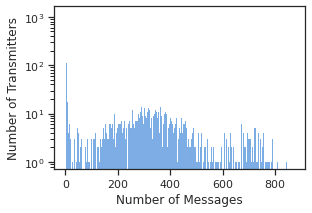

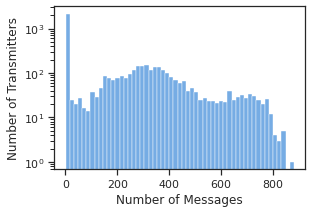

In [ ]:
with sns.color_palette(colors_hex[1:2]):
    plot_distribution(id_cells_array, True, (4.5, 3), "iridium-histogram-discrete.pdf")
    plot_distribution(id_cells_array, False, (4.5, 3), "iridium-histogram.pdf")

In [21]:
id_cells_unique, id_cells_counts = np.unique(id_cells_array, return_counts=True)
id_cells_unique = id_cells_unique[np.argsort(id_cells_counts)][::-1]
id_cells_counts = np.sort(id_cells_counts)[::-1]

max_messages_per_transmitter = np.max(id_cells_counts)
mean_messages_per_transmitter = np.mean(id_cells_counts)
median_messages_per_transmitter = np.median(id_cells_counts)

print(f"Max messages per transmitter:    {max_messages_per_transmitter:3.2f}")
print(f"Mean messages per transmitter:   {mean_messages_per_transmitter:3.2f}")
print(f"Median messages per transmitter: {median_messages_per_transmitter:3.2f}")

Max messages per transmitter:    872.00
Mean messages per transmitter:   202.90
Median messages per transmitter: 166.00


In [33]:
del ids_array
del cells_array
del id_cells_array